In [3]:
from mingpt.utils import set_seed
import numpy as np
import scipy as sp
import torch
import torch.nn as nn
from torch.nn import functional as F
import math
from torch.utils.data import Dataset, DataLoader
from mingpt.model import GPT
from mingpt.trainer import Trainer
from mingpt.utils import set_seed, setup_logging, CfgNode as CN
import time

import routegym.env
import networkx as nx

sparsity = 0.55
[[0 0 0 1 1 0 1 0 0 0 1 0]
 [1 0 0 0 0 0 1 1 0 1 0 0]
 [1 1 0 1 0 1 1 0 0 1 1 0]
 [1 1 0 0 1 1 1 1 0 0 0 1]
 [1 0 0 1 0 0 1 0 0 1 0 1]
 [1 0 1 0 1 0 1 0 1 1 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 1]
 [1 0 1 0 1 0 0 0 1 0 0 1]
 [0 1 1 0 0 0 0 1 0 1 0 0]
 [1 1 0 1 1 0 0 0 0 0 0 0]
 [0 1 1 1 1 1 0 1 0 0 0 1]
 [1 0 1 1 1 1 1 1 1 1 1 0]]


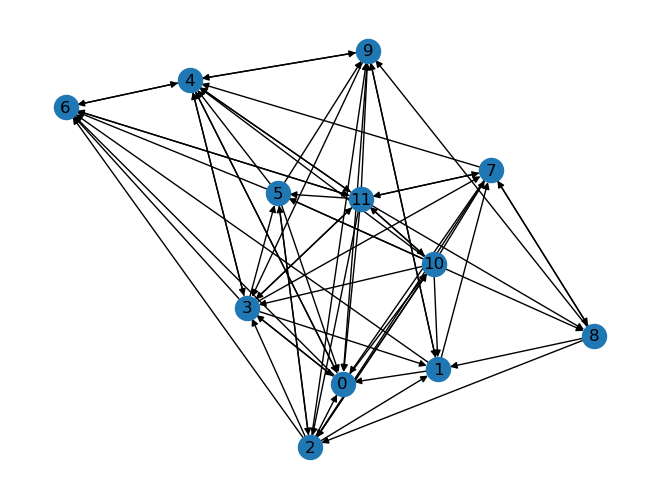

In [4]:
node_number = 12

env = None
while env is None:
    try:
        A = sp.sparse.random(node_number, node_number, density=0.5, format='csr')
        A.data[:] = 1
        A = A.todense()
        A = np.ma.array(A, mask=np.eye(node_number)).filled(fill_value=0).astype(int)
        print("sparsity = %.2f" % (1 - np.sum(A)/A.size))
        G = nx.from_numpy_array(A, create_using=nx.DiGraph)
        env = routegym.env.ShortestRouteEnv(G, 0, 5, random_weights=(1,10))
    except:
        pass
# env.render()
# print(A)
# print(env.graph.adj_mat)
# print(env.get_dijkstra())
print(nx.adjacency_matrix(G).todense())
nx.draw(G, with_labels=True)

In [5]:
rew = 0
position = 0
env.reset()
done = False
print("Position: {%d " % position, end='')
while not done:
    action = np.random.choice(np.arange(0, env.graph.adj_mat.shape[0]))
    position, reward, done, _ = env.step(action)
    # env.render()
    print("%d, " % position, end='')
    rew += reward
print("}\n")
print("Final reward: %.2f" % rew)
env.reset()
done

Position: {0 0, 10, 10, 10, 10, 10, 10, 10, 2, 10, 10, 7, 11, 9, 4, 4, 6, 6, 6, 6, 6, 6, 6, 6, 4, 3, 0, 0, 0, 0, 0, 0, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4, 4, 11, 3, 11, 6, 11, 11, 9, 9, 9, 4, 4, 4, 3, 3, 3, 5, }

Final reward: -60.00


True

In [39]:
obss = []
actions = []
returns = [0]
done_idxs = []
stepwise_returns = []

for i in range(10):
    ac = np.random.choice(np.arange(0, env.graph.adj_mat.shape[0]))
    state, reward, terminal, _ = env.step(ac)
    print(state)
    obss += [state]
    actions += [ac]
    stepwise_returns += [reward]
    if terminal:
        print("Terminal!")
        done_idxs += [len(obss)]
        returns += [0]
        env.reset()
        break

4
0
0
0
0
0
3
3
5
Terminal!


In [41]:
actions, stepwise_returns, i

([7, 0, 5, 9, 0, 7, 3, 8, 5],
 [-1.0, -1, -1.0, -1.0, -1.0, -1.0, -1, -1.0, 0],
 8)

In [52]:
env.reset()

num_steps = 10_000

def create_dataset():
    obss = []
    actions = []
    returns = [0]
    done_idxs = []
    stepwise_returns = []

    # simulate to create trajectories
    transitions_per_buffer = np.zeros(50, dtype=int)
    num_trajectories = 0
    while len(obss) < num_steps:
        for _ in range(10):
            ac = np.random.choice(np.arange(0, env.graph.adj_mat.shape[0]))
            state, reward, terminal, _ = env.step(ac)
            obss += [state]
            actions += [ac]
            stepwise_returns += [reward]
            if terminal:
                done_idxs += [len(obss)]
                returns += [0]
                env.reset()
                break

    actions = np.array(actions)
    returns = np.array(returns)
    stepwise_returns = np.array(stepwise_returns)
    done_idxs = np.array(done_idxs)

    # create reward-to-go dataset
    start_index = 0
    rtg = np.zeros_like(stepwise_returns)
    for i in done_idxs:
        i = int(i)
        curr_traj_returns = stepwise_returns[start_index:i]
        for j in range(i-1, start_index-1, -1): # start from i-1
            rtg_j = curr_traj_returns[j-start_index:i-start_index]
            rtg[j] = sum(rtg_j)
        start_index = i
    print('max rtg is %d' % max(rtg))

    # create timestep dataset
    start_index = 0
    timesteps = np.zeros(len(actions)+1, dtype=int)
    for i in done_idxs:
        i = int(i)
        timesteps[start_index:i+1] = np.arange(i+1 - start_index)
        start_index = i+1
    print('max timesteps is %d' % max(timesteps))

    return obss, actions, returns, done_idxs, rtg, timesteps

In [56]:
obss, actions, returns, done_idxs, rtgs, timesteps = create_dataset()

max rtg is 0
max timesteps is 314


In [60]:
(done_idxs[1:11], 
 obss[done_idxs[4]-15:done_idxs[4]+5], 
 actions[done_idxs[4]-15:done_idxs[4]+5], 
 rtgs[done_idxs[4]-15:done_idxs[4]+5])

(array([ 10,  16,  19,  51,  93, 224, 341, 444, 464, 484]),
 [6, 6, 4, 4, 4, 4, 4, 4, 9, 9, 9, 4, 4, 3, 5, 0, 0, 6, 6, 6],
 array([ 5,  5,  4, 10,  8,  8,  1,  2,  9,  7,  2,  4,  5,  3,  5, 11,  5,
         6,  2,  6]),
 array([-14., -13., -12., -11., -10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,
         -3.,  -2.,  -1.,   0., -41., -40., -39., -38., -37.]))

In [9]:
class StateActionReturnDataset(Dataset):

    @staticmethod
    def get_default_config():
        C = CN()
        C.block_size = 10 * 3
        return C

    def __init__(self, data, block_size, actions, done_idxs, rtgs, timesteps):
        self.block_size = block_size
        self.vocab_size = max(actions) + 1
        self.data = data
        self.actions = actions
        self.done_idxs = done_idxs
        self.rtgs = rtgs
        self.timesteps = timesteps

    def __len__(self):
        return len(self.data) - self.block_size

    def __getitem__(self, idx):
        block_size = self.block_size // 3
        done_idx = idx + block_size
        for i in self.done_idxs:
            if i > idx: # first done_idx is greater than idx
                done_idx = min(int(i), done_idx)
                break
        idx = done_idx - block_size
        states = torch.tensor(np.array(self.data[idx:done_idx]), dtype=torch.float32).reshape(block_size, -1) # (block_size, state_dim)
        actions = torch.tensor(self.actions[idx:done_idx], dtype=torch.long).unsqueeze(1) # (block_size, 1)
        rtgs = torch.tensor(self.rtgs[idx:done_idx], dtype=torch.float32).unsqueeze(1) # (block_size, 1)
        timesteps = torch.tensor(self.timesteps[idx:idx+1], dtype=torch.int64).unsqueeze(1) # (block_size, 1)

        return states, actions, rtgs, timesteps

In [10]:
C = CN()

# system
C.system = CN()
C.system.seed = 3407
C.system.work_dir = './out/decgpt'

# data
C.data = StateActionReturnDataset.get_default_config()

# model 
C.model = GPT.get_default_config()
C.model.model_type = 'gpt-mini'

# trainer
C.trainer = Trainer.get_default_config()
C.trainer.learning_rate = 5e-4
C.trainer.max_epochs = 50
C.trainer.num_workers = 4

In [11]:
train_dataset = StateActionReturnDataset(obss, 10 * 3, actions, done_idxs, rtgs, timesteps)


In [12]:
C.model.vocab_size = train_dataset.vocab_size
C.model.block_size = train_dataset.block_size
C.model.max_timestep = max(timesteps)
C.model.max_timestep

10

In [13]:
model = GPT(C.model)

number of parameters: 2.68M


In [14]:
loader = DataLoader(train_dataset, shuffle=True, pin_memory=True, batch_size=4)

In [15]:
for _ in range(121):
    x, y, r, t = next(iter(loader))

In [16]:
x, y, r, t = next(iter(loader))

In [17]:
x[0], y[0], r[0]

(tensor([[ 1.],
         [ 6.],
         [ 7.],
         [ 9.],
         [ 3.],
         [10.],
         [10.],
         [10.],
         [ 3.],
         [ 4.]]),
 tensor([[ 1],
         [ 6],
         [ 7],
         [ 9],
         [ 3],
         [10],
         [ 7],
         [ 8],
         [ 3],
         [ 4]]),
 tensor([[-10.],
         [ -9.],
         [ -8.],
         [ -7.],
         [ -6.],
         [ -5.],
         [ -4.],
         [ -3.],
         [ -2.],
         [ -1.]]))

In [18]:
model(x, y, y, r, t)

(tensor([[[ 0.5685,  0.3465, -0.1596, -0.0866,  0.2747,  0.0338, -0.2244,
           -0.4075, -0.5055,  0.0378,  0.2395,  0.0979],
          [ 0.0778, -0.3410, -0.0513,  0.1057,  0.1138, -0.3280,  0.0627,
           -0.0274, -0.0927,  0.2799,  0.3806,  0.2600],
          [ 0.0874, -0.2553,  0.0742,  0.1429, -0.0403, -0.0650,  0.0403,
           -0.1001,  0.0513,  0.3312,  0.4148,  0.3459],
          [ 0.1040, -0.2905,  0.0391,  0.0608, -0.1039, -0.3206,  0.1253,
           -0.0199, -0.0414,  0.1425,  0.2809,  0.2161],
          [ 0.0603, -0.1545, -0.0532,  0.0574,  0.0139, -0.0307,  0.0689,
           -0.3291, -0.3551,  0.2118,  0.4061,  0.2891],
          [ 0.0571, -0.2918, -0.1590,  0.0678, -0.1069, -0.3736,  0.2272,
            0.0291, -0.1392,  0.2147,  0.3610,  0.1558],
          [-0.0136, -0.3271, -0.0799,  0.0912, -0.0489, -0.2473,  0.2224,
            0.1369,  0.0235,  0.2077,  0.3458,  0.1029],
          [ 0.2048, -0.3515,  0.1745,  0.0411, -0.2086, -0.4620, -0.0018,
         

In [19]:
trainer = Trainer(model, train_dataset, C.trainer)

running on device cuda


In [20]:
trainer.run()

/home/icute/mambaforge/envs/dec-transformer-route/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
epoch 1 iter 155: train loss 0.78362. lr 5.000000e-04:  99%|█████████▉| 155/156 [00:02<00:00, 67.31it/s]/home/icute/mambaforge/envs/dec-transformer-route/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
epoch 1 iter 155: train loss 0.78362. lr 5.000000e-04: 100%|██████████| 156/156 [00:02<00:00, 62.80it/s]
epoch 2 iter 155: train loss 0.54923. lr 5.000000e-04: 100%|██████████| 156/156 [00:02<00:00, 67.94it/s]
epoch 3 iter 155: train loss 0.49772. lr 5.000000e-04: 100%|██████████| 156/156 [00:02<00:00, 67.97it/s]
epoch 4 iter 155: train los

In [21]:
model.eval()
with torch.no_grad():
    done = True
    for i in range(10):
        # sample from the model
        state = torch.tensor(env.reset())
        state = state.type(torch.float32).to(trainer.device).unsqueeze(0).unsqueeze(0)
        rtgs = [10+1-2]
        # first state is from env, first rtg is target return, and first timestep is 0
        sampled_action = model.generate(state, 1, temperature=1.0, do_sample=True, actions=None, 
                            rtgs=torch.tensor(rtgs, dtype=torch.long).to(trainer.device).unsqueeze(0).unsqueeze(-1),
                            timesteps=torch.zeros((1, 1, 1), dtype=torch.int64).to(trainer.device))

        j = 0
        all_states = state
        actions = []
        while True:
            if done:
                state, reward_sum, done = torch.tensor(env.reset()), 0, False
            action = sampled_action.cpu().numpy()[0, -1]
            actions += [sampled_action]
            state, reward, done, _ = env.step(action)
            reward_sum += reward
            j += 1

            if done:
                break

            state = torch.tensor(state).unsqueeze(0).unsqueeze(0).to(trainer.device)

            all_states = torch.cat([all_states, state], dim=0)

            rtgs += [rtgs[-1] - reward]
            # all_states has all previous states and rtgs has all revious rtgs (weill be cut to block_size in trainer.generate)
            # timestep is just the current timestep
            sampled_action = model.generate(all_states.unsqueeze(0), 1, temperature=1.0, do_sample=True, 
                            actions=torch.tensor(actions, dtype=torch.long).to(trainer.device).unsqueeze(-1).unsqueeze(0),
                            rtgs=torch.tensor(rtgs, dtype=torch.long).to(trainer.device).unsqueeze(0).unsqueeze(-1),
                            timesteps=(min(j, model.config.max_timestep) * torch.ones((1, 1, 1), dtype=torch.int64).to(trainer.device)))

KeyboardInterrupt: 